In [4]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source('tests.R')
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [5]:
#reading the dataset
game <- read_csv("game_results.csv")
game

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2881,2017-0605,Tour Finals,Hard,8,F,20171113,300,105777,6.0,⋯,54,42,22,15,11,15,6,3650,8,2975
2882,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,1,105676,NA,⋯,53,33,21,14,6,11,7,3775,18,2235
2883,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,⋯,54,30,12,12,5,11,15,2320,76,667


In [6]:
#selecting the needed columns and mutating the variables
transformed_game<- select(game, tourney_name, winner_rank, loser_rank, minutes) |>
                    mutate( rank_diff = loser_rank - winner_rank)

transformed_game

tourney_name,winner_rank,loser_rank,minutes,rank_diff
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Brisbane,9,16,124,7
Brisbane,16,239,82,223
Brisbane,9,40,66,31
Brisbane,239,31,106,-208
Brisbane,16,18,129,2
⋮,⋮,⋮,⋮,⋮
Tour Finals,6,8,150,2
Davis Cup WG F: BEL vs FRA,7,18,119,11
Davis Cup WG F: BEL vs FRA,15,76,106,61


Warning message:
“Removed 127 rows containing missing values (`geom_point()`).”


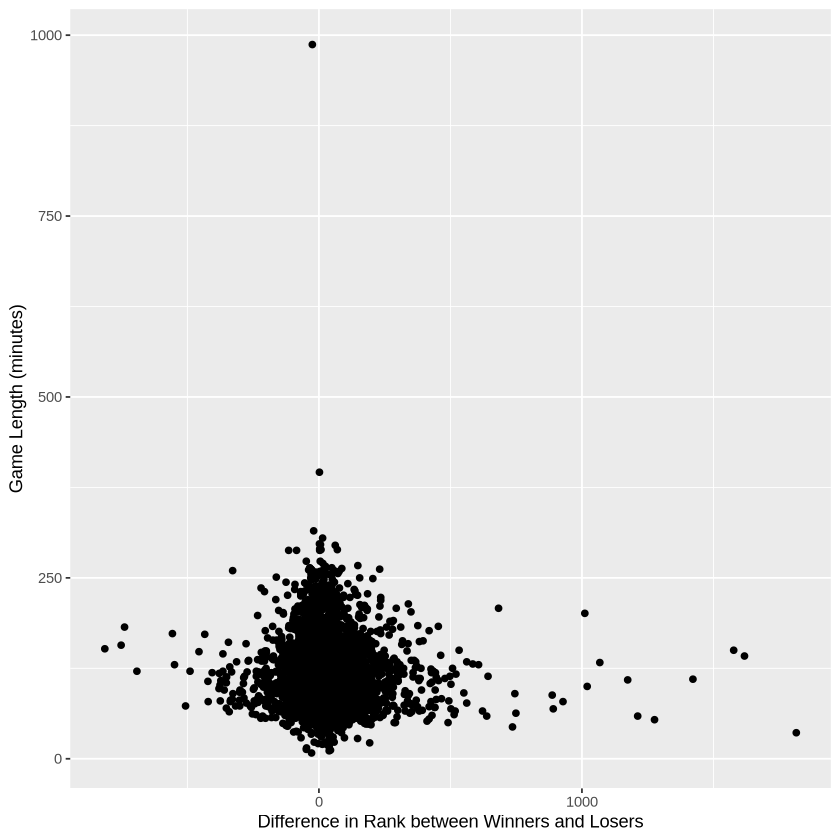

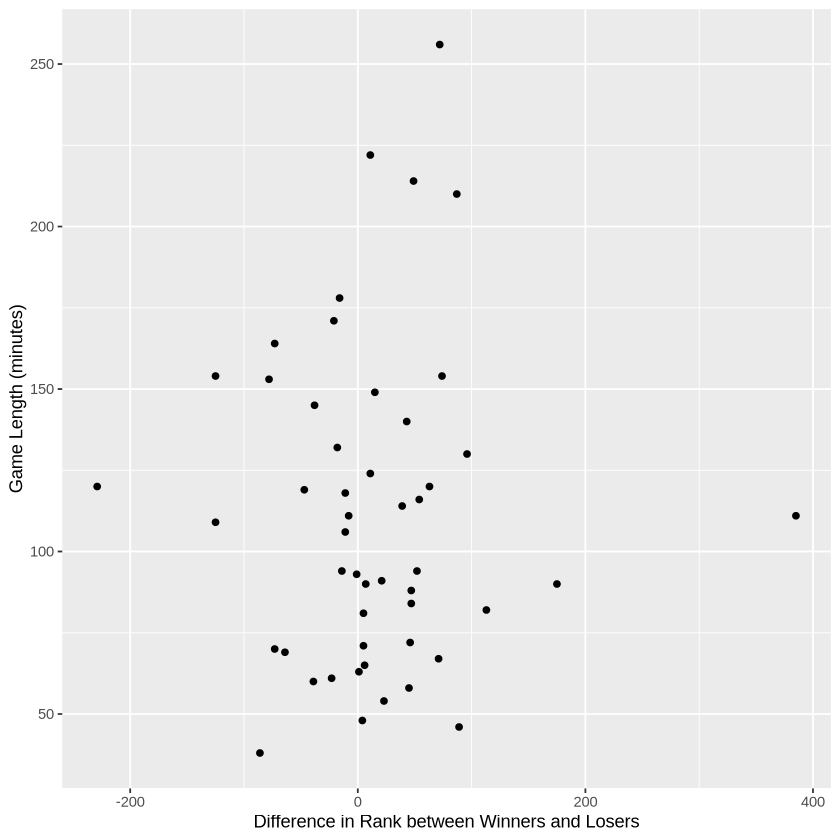

In [13]:
#making the plot
game_plot <- transformed_game |>
                ggplot(aes(x = rank_diff, y = minutes)) +
                geom_point() +
                xlab("Difference in Rank between Winners and Losers") +
                ylab("Game Length (minutes)") 


game_50 <- transformed_game |>
                sample_n(50)

game_plot_50 <- game_50 |>
                ggplot(aes(x = rank_diff, y = minutes)) +
                geom_point() +
                xlab("Difference in Rank between Winners and Losers") +
                ylab("Game Length (minutes)") 

#before using sample_n(), i tried using facet_grid(cols = vars(tourney_name)) because the data is so condensed but it crashes my computer
#so instead, here's a comparison between all the points and just 50 random samples for now
game_plot
game_plot_50

In [25]:
#splitting the data 
game_split <- initial_split(transformed_game, prop = 0.5, strata = minutes)
game_training <- training(game_split)
game_testing <- testing(game_split)

In [27]:
#making the workflow
game_recipe <- recipe(minutes ~ rank_diff, data = game_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

game_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression") 

game_vfold <- vfold_cv(game_training, v=5, strata = minutes)

game_workflow <- workflow() |>
    add_recipe(game_recipe) |>
    add_model(game_spec)

game_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [ ]:
source("cleanup.R")